#Download do Dataset

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T000823Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dad26e7c150995e74f3f938548176d152f2bfc44273552b881c9124697dd6e89d4e5f259e188dfc21bf6ff925669a6c8a95fbace1de5f2fee02631a7cd15267b7c1051372cb741bdc85ecce3864ef69e3bc04286f08bda0b8a4e9456fb448c89bf43238d3c590cd0b05157969432efca232c9002e256637c55e2f35499700590e29332d00db88615aa2e0beaa2f66fdc1d95a3d1ddc220839487e8e94687be31b65940d313edacdb413507fbd06cdd7356acb6d83346ee7599a06752ed160583d2e15e9eeb5c5a8f09442ee019e57d68dbe864f3ccfc2914ba3aa561e68327a43331c02681e5df7fe23dc83364414e2eddbc2a897e352d734b2b49deb52254e80'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


#Instalação das Bibliotecas

In [3]:
!pip install pandas numpy matplotlib seaborn tqdm opencv-python torch torchsummary torchmetrics

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-4-6530242ea47a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'cuda'

# Carregamento do Dataset

In [5]:
PATH = '/kaggle/input/eye-diseases-classification/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
2117,/kaggle/input/eye-diseases-classification/data...,2
3029,/kaggle/input/eye-diseases-classification/data...,2
1979,/kaggle/input/eye-diseases-classification/data...,1
3828,/kaggle/input/eye-diseases-classification/data...,3
3860,/kaggle/input/eye-diseases-classification/data...,3


## Gráfico de distribuição de dados

<ipython-input-6-949d57b1b1b9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

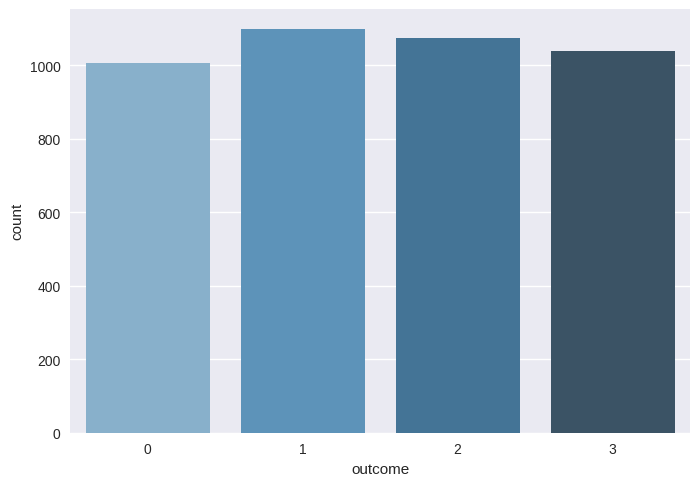

In [6]:
sea.countplot(x = 'outcome', data = df, palette = 'Set2')

## Print de Algumas imagens

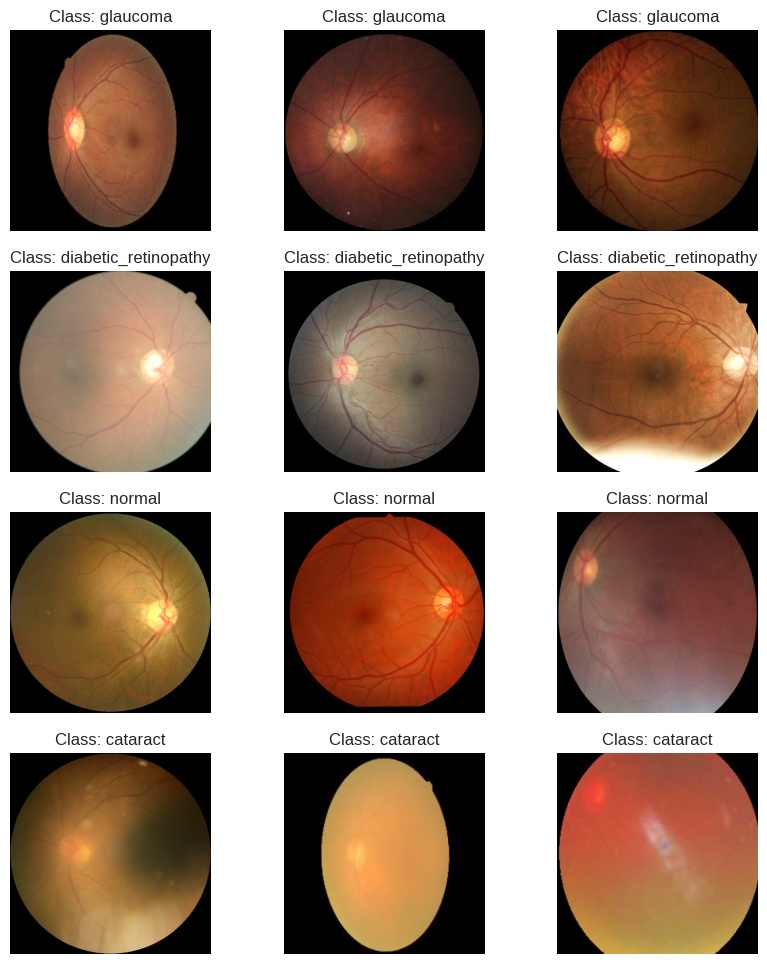

In [7]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

# Pré-Processamento

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

### Augmentation

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.5),
    transforms.RandomRotation(degrees = 15)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

###Dataloader

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

## Distribuição do Dataset

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

## Definição de Parametros

In [ ]:
NUM_CLASSES = 4
BATCH_SIZE = 128

## Carregamento do Dataloader

In [10]:
rain_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [11]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


# Modelo

In [12]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.mobilenet_v2(pretrained = True) ### Definição do modelo

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()

        self.additional_layer = nn.Linear(1280, 512) # Adicional Layer

    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.additional_layer(x) #Adicional Layer
        x = self.block(x)
        return x


class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [13]:
trainer = Trainer(train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Resumo do Modelo

In [14]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                            [-1, 32, 112, 112]        (864)
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 112, 112]        (64)
|    |    └─ReLU6: 3-3                             [-1, 32, 112, 112]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                        [-1, 16, 112, 112]        (896)
|    └─InvertedResidual: 2-3                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                        [-1, 24, 56, 56]          (5,136)
|    └─InvertedResidual: 2-4                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                        [-1, 24, 56, 56]          (8,832)
|    └─InvertedRe

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 7, 7]          --
|    └─Conv2dNormActivation: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                            [-1, 32, 112, 112]        (864)
|    |    └─BatchNorm2d: 3-2                       [-1, 32, 112, 112]        (64)
|    |    └─ReLU6: 3-3                             [-1, 32, 112, 112]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                        [-1, 16, 112, 112]        (896)
|    └─InvertedResidual: 2-3                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                        [-1, 24, 56, 56]          (5,136)
|    └─InvertedResidual: 2-4                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                        [-1, 24, 56, 56]          (8,832)
|    └─InvertedRe

# Treinamento

In [15]:
trainer.train(epochs = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.960 acc: 0.674] Val: [loss: 0.590 acc:0.766]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.553 acc: 0.784] Val: [loss: 0.453 acc:0.824]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.450 acc: 0.828] Val: [loss: 0.378 acc:0.856]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.383 acc: 0.854] Val: [loss: 0.346 acc:0.872]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.356 acc: 0.862] Val: [loss: 0.325 acc:0.868]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.318 acc: 0.879] Val: [loss: 0.346 acc:0.872]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.317 acc: 0.880] Val: [loss: 0.307 acc:0.886]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.298 acc: 0.887] Val: [loss: 0.312 acc:0.881]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.276 acc: 0.897] Val: [loss: 0.311 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.272 acc: 0.898] Val: [loss: 0.298 acc:0.891]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.262 acc: 0.895] Val: [loss: 0.295 acc:0.891]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 12] Train: [loss: 0.254 acc: 0.903] Val: [loss: 0.271 acc:0.892]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 13] Train: [loss: 0.242 acc: 0.908] Val: [loss: 0.287 acc:0.893]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 14] Train: [loss: 0.231 acc: 0.915] Val: [loss: 0.298 acc:0.883]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 15] Train: [loss: 0.241 acc: 0.908] Val: [loss: 0.265 acc:0.904]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 16] Train: [loss: 0.221 acc: 0.914] Val: [loss: 0.253 acc:0.897]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 17] Train: [loss: 0.214 acc: 0.914] Val: [loss: 0.265 acc:0.902]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 18] Train: [loss: 0.210 acc: 0.917] Val: [loss: 0.269 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 19] Train: [loss: 0.195 acc: 0.922] Val: [loss: 0.283 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 20] Train: [loss: 0.194 acc: 0.927] Val: [loss: 0.288 acc:0.899]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 21] Train: [loss: 0.200 acc: 0.925] Val: [loss: 0.261 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 22] Train: [loss: 0.194 acc: 0.924] Val: [loss: 0.266 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 23] Train: [loss: 0.203 acc: 0.921] Val: [loss: 0.265 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 24] Train: [loss: 0.181 acc: 0.932] Val: [loss: 0.259 acc:0.905]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 25] Train: [loss: 0.178 acc: 0.929] Val: [loss: 0.252 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 26] Train: [loss: 0.174 acc: 0.929] Val: [loss: 0.257 acc:0.899]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 27] Train: [loss: 0.181 acc: 0.932] Val: [loss: 0.257 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 28] Train: [loss: 0.166 acc: 0.938] Val: [loss: 0.240 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 29] Train: [loss: 0.161 acc: 0.935] Val: [loss: 0.256 acc:0.899]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 30] Train: [loss: 0.153 acc: 0.943] Val: [loss: 0.253 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 31] Train: [loss: 0.157 acc: 0.938] Val: [loss: 0.249 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 32] Train: [loss: 0.165 acc: 0.936] Val: [loss: 0.265 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 33] Train: [loss: 0.150 acc: 0.942] Val: [loss: 0.269 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 34] Train: [loss: 0.143 acc: 0.943] Val: [loss: 0.253 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 35] Train: [loss: 0.133 acc: 0.943] Val: [loss: 0.244 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 36] Train: [loss: 0.139 acc: 0.941] Val: [loss: 0.253 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 37] Train: [loss: 0.141 acc: 0.944] Val: [loss: 0.252 acc:0.905]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 38] Train: [loss: 0.134 acc: 0.947] Val: [loss: 0.264 acc:0.908]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 39] Train: [loss: 0.134 acc: 0.946] Val: [loss: 0.252 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 40] Train: [loss: 0.137 acc: 0.946] Val: [loss: 0.261 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 41] Train: [loss: 0.137 acc: 0.944] Val: [loss: 0.267 acc:0.894]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 42] Train: [loss: 0.127 acc: 0.949] Val: [loss: 0.256 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 43] Train: [loss: 0.118 acc: 0.954] Val: [loss: 0.270 acc:0.902]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 44] Train: [loss: 0.120 acc: 0.955] Val: [loss: 0.281 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 45] Train: [loss: 0.114 acc: 0.959] Val: [loss: 0.264 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 46] Train: [loss: 0.105 acc: 0.957] Val: [loss: 0.265 acc:0.911]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 47] Train: [loss: 0.118 acc: 0.955] Val: [loss: 0.246 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 48] Train: [loss: 0.116 acc: 0.956] Val: [loss: 0.249 acc:0.915]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 49] Train: [loss: 0.122 acc: 0.949] Val: [loss: 0.240 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 50] Train: [loss: 0.112 acc: 0.954] Val: [loss: 0.272 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 51] Train: [loss: 0.107 acc: 0.958] Val: [loss: 0.268 acc:0.911]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 52] Train: [loss: 0.115 acc: 0.954] Val: [loss: 0.247 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 53] Train: [loss: 0.108 acc: 0.958] Val: [loss: 0.244 acc:0.908]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 54] Train: [loss: 0.106 acc: 0.960] Val: [loss: 0.266 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 55] Train: [loss: 0.108 acc: 0.957] Val: [loss: 0.260 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 56] Train: [loss: 0.091 acc: 0.965] Val: [loss: 0.250 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 57] Train: [loss: 0.111 acc: 0.960] Val: [loss: 0.253 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 58] Train: [loss: 0.101 acc: 0.959] Val: [loss: 0.276 acc:0.898]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 59] Train: [loss: 0.084 acc: 0.966] Val: [loss: 0.260 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 60] Train: [loss: 0.089 acc: 0.965] Val: [loss: 0.257 acc:0.913]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 61] Train: [loss: 0.092 acc: 0.965] Val: [loss: 0.238 acc:0.918]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 62] Train: [loss: 0.087 acc: 0.967] Val: [loss: 0.235 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 63] Train: [loss: 0.093 acc: 0.964] Val: [loss: 0.256 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 64] Train: [loss: 0.089 acc: 0.964] Val: [loss: 0.235 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 65] Train: [loss: 0.085 acc: 0.968] Val: [loss: 0.259 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 66] Train: [loss: 0.088 acc: 0.966] Val: [loss: 0.237 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 67] Train: [loss: 0.074 acc: 0.973] Val: [loss: 0.257 acc:0.913]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 68] Train: [loss: 0.094 acc: 0.963] Val: [loss: 0.224 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 69] Train: [loss: 0.083 acc: 0.967] Val: [loss: 0.245 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 70] Train: [loss: 0.077 acc: 0.973] Val: [loss: 0.246 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 71] Train: [loss: 0.080 acc: 0.971] Val: [loss: 0.230 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 72] Train: [loss: 0.073 acc: 0.973] Val: [loss: 0.239 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 73] Train: [loss: 0.076 acc: 0.971] Val: [loss: 0.244 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 74] Train: [loss: 0.091 acc: 0.966] Val: [loss: 0.257 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 75] Train: [loss: 0.079 acc: 0.972] Val: [loss: 0.235 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 76] Train: [loss: 0.063 acc: 0.977] Val: [loss: 0.221 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 77] Train: [loss: 0.067 acc: 0.974] Val: [loss: 0.250 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 78] Train: [loss: 0.070 acc: 0.973] Val: [loss: 0.250 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 79] Train: [loss: 0.067 acc: 0.976] Val: [loss: 0.252 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 80] Train: [loss: 0.067 acc: 0.977] Val: [loss: 0.241 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 81] Train: [loss: 0.068 acc: 0.973] Val: [loss: 0.231 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 82] Train: [loss: 0.054 acc: 0.980] Val: [loss: 0.242 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 83] Train: [loss: 0.063 acc: 0.975] Val: [loss: 0.233 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 84] Train: [loss: 0.071 acc: 0.973] Val: [loss: 0.261 acc:0.917]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 85] Train: [loss: 0.064 acc: 0.975] Val: [loss: 0.235 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 86] Train: [loss: 0.063 acc: 0.977] Val: [loss: 0.252 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 87] Train: [loss: 0.057 acc: 0.979] Val: [loss: 0.227 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 88] Train: [loss: 0.061 acc: 0.977] Val: [loss: 0.243 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 89] Train: [loss: 0.060 acc: 0.979] Val: [loss: 0.249 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 90] Train: [loss: 0.055 acc: 0.980] Val: [loss: 0.215 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 91] Train: [loss: 0.050 acc: 0.984] Val: [loss: 0.250 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 92] Train: [loss: 0.059 acc: 0.977] Val: [loss: 0.238 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 93] Train: [loss: 0.066 acc: 0.975] Val: [loss: 0.222 acc:0.930]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 94] Train: [loss: 0.059 acc: 0.977] Val: [loss: 0.220 acc:0.930]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 95] Train: [loss: 0.052 acc: 0.980] Val: [loss: 0.261 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 96] Train: [loss: 0.051 acc: 0.981] Val: [loss: 0.228 acc:0.933]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 97] Train: [loss: 0.057 acc: 0.979] Val: [loss: 0.232 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 98] Train: [loss: 0.053 acc: 0.980] Val: [loss: 0.239 acc:0.932]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 99] Train: [loss: 0.048 acc: 0.982] Val: [loss: 0.242 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 100] Train: [loss: 0.051 acc: 0.981] Val: [loss: 0.262 acc:0.919]


# Resultado do Treinamento

## Loss e Acurácia

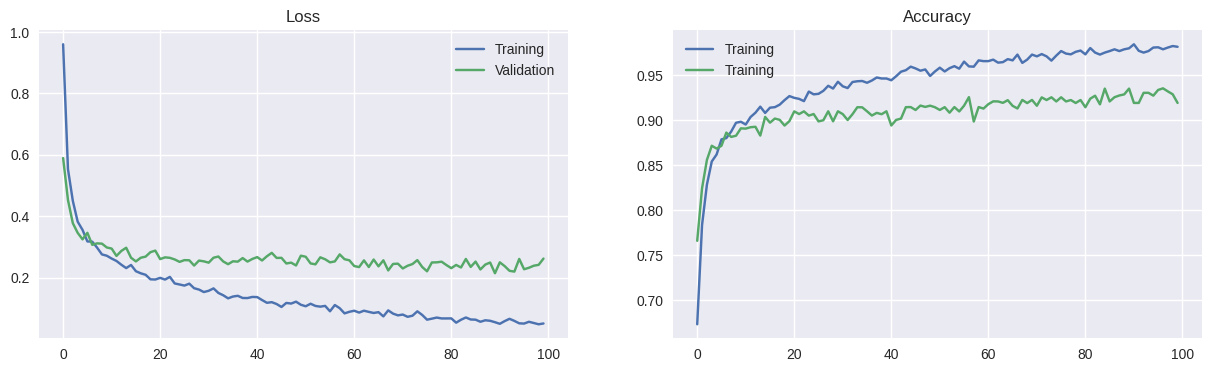

In [20]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()



# Predição do dataset de Validação

In [21]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

#Matriz de Confusão

Text(0.5, 1.0, 'Confusion Matrix')

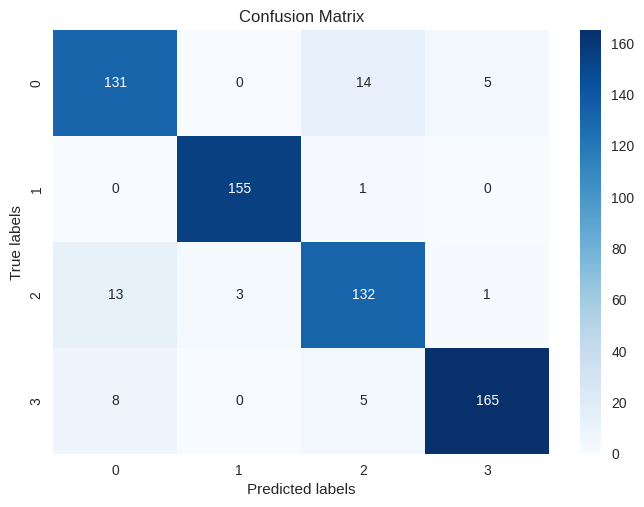

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [23]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            glaucoma       0.86      0.87      0.87       150
diabetic_retinopathy       0.98      0.99      0.99       156
              normal       0.87      0.89      0.88       149
            cataract       0.96      0.93      0.95       178

            accuracy                           0.92       633
           macro avg       0.92      0.92      0.92       633
        weighted avg       0.92      0.92      0.92       633

